In [21]:
#Numpy:  librería de Python especializada en el cálculo numérico y el análisis de datos.
import numpy as np

#Matplotlib: librería de Python especializada en la creación de gráficos en dos dimensiones.
import matplotlib.pyplot as plt

#esta libreria permite caragar un
from joblib import load as ld

#para importar los archivos de audio
from scipy.io import wavfile as wav

from scipy.signal import filtfilt, hilbert

import sys

In [22]:
#concecta con google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pickle

model_path = '/content/drive/MyDrive/IA/Investigacion /EMG/KNN/knn_model.pkl'

from joblib import load as ld

try:
  model = ld(model_path)
  print("Model loaded successfully!")
except Exception as e:
  print(f"Error loading the model: {e}")

Error loading the model: [Errno 2] No such file or directory: '/content/drive/MyDrive/IA/Investigacion /EMG/KNN/knn_model.pkl'


In [36]:
ruta_archivo = '/content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Porrismo/S2_POR_TRI.wav'
try:
  print("importando registro " + ruta_archivo)
  [Fs, Signal] = wav.read(ruta_archivo)
except:
  print("Error al importar el registro")
  sys.exit()

importando registro /content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Porrismo/S2_POR_TRI.wav


In [25]:
pip install antropy

In [37]:
from antropy import hjorth_params

window_size_samples = 500
step_size_samples = 50  # 90% overlap

hjorth_features = []

for start_sample in range(0, len(Signal) - window_size_samples + 1, step_size_samples):
    end_sample = start_sample + window_size_samples
    segment = Signal[start_sample:end_sample]

    analytic_signal = hilbert(segment)
    analytic_real = np.real(analytic_signal)

    # Calcular Hjorth con antropy (solo devuelve movilidad y complejidad)
    mobility, complexity = hjorth_params(analytic_real)

    # Calcular actividad (varianza del segmento)
    activity = np.var(analytic_real)

    # Guardar características
    hjorth_features.append([activity, mobility, complexity])

hjorth_features = np.array(hjorth_features)

# Normalización min-max por columna
min_vals = np.min(hjorth_features, axis=0)
max_vals = np.max(hjorth_features, axis=0)
hjorth_features_norm = (hjorth_features - min_vals) / (max_vals - min_vals)

# Predicciones
predictions = []
for features in hjorth_features_norm:
    features = features.reshape(1, -1)
    prediction = model.predict(features)
    predictions.append(prediction[0])


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier 

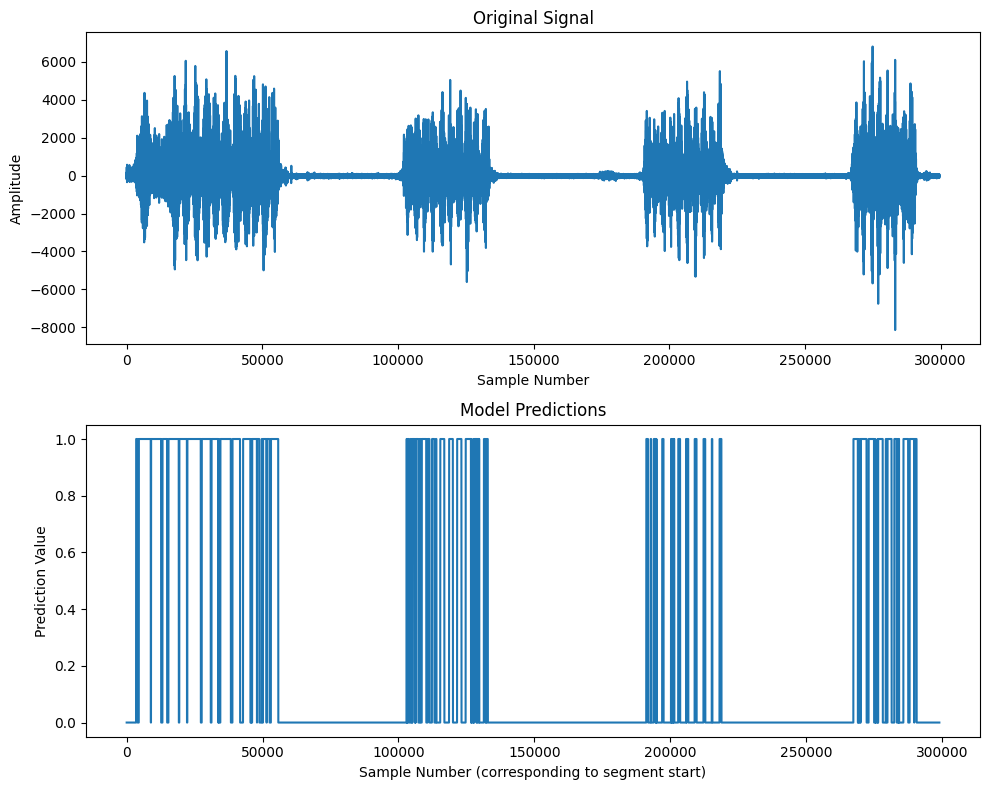

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Plot the predictions
# We need to create a time axis or index for the predictions
# Assuming each prediction corresponds to the start of a segment
prediction_indices = np.arange(len(predictions)) * step_size_samples

axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

In [39]:
from scipy.ndimage import binary_closing, binary_dilation

def prob_smooth_and_threshold(probs, window_size, thr=0.5):
    """
    Suavizado de probabilidades con media móvil y umbral.
    probs: 1D numpy array de probabilidades [0..1]
    window_size: ventana para la media móvil (>=1)
    thr: umbral final para pasar a etiqueta binaria
    devuelve: etiquetas 0/1
    """
    kernel = np.ones(window_size) / window_size
    # convolución válida con padding reflect
    padded = np.pad(probs, (window_size//2,), mode='reflect')
    smoothed = np.convolve(padded, kernel, mode='valid')
    return (smoothed >= thr).astype(int)

In [40]:
predictions = np.array(predictions, dtype=int)

withprob = prob_smooth_and_threshold(predictions, window_size=150, thr=0.1)

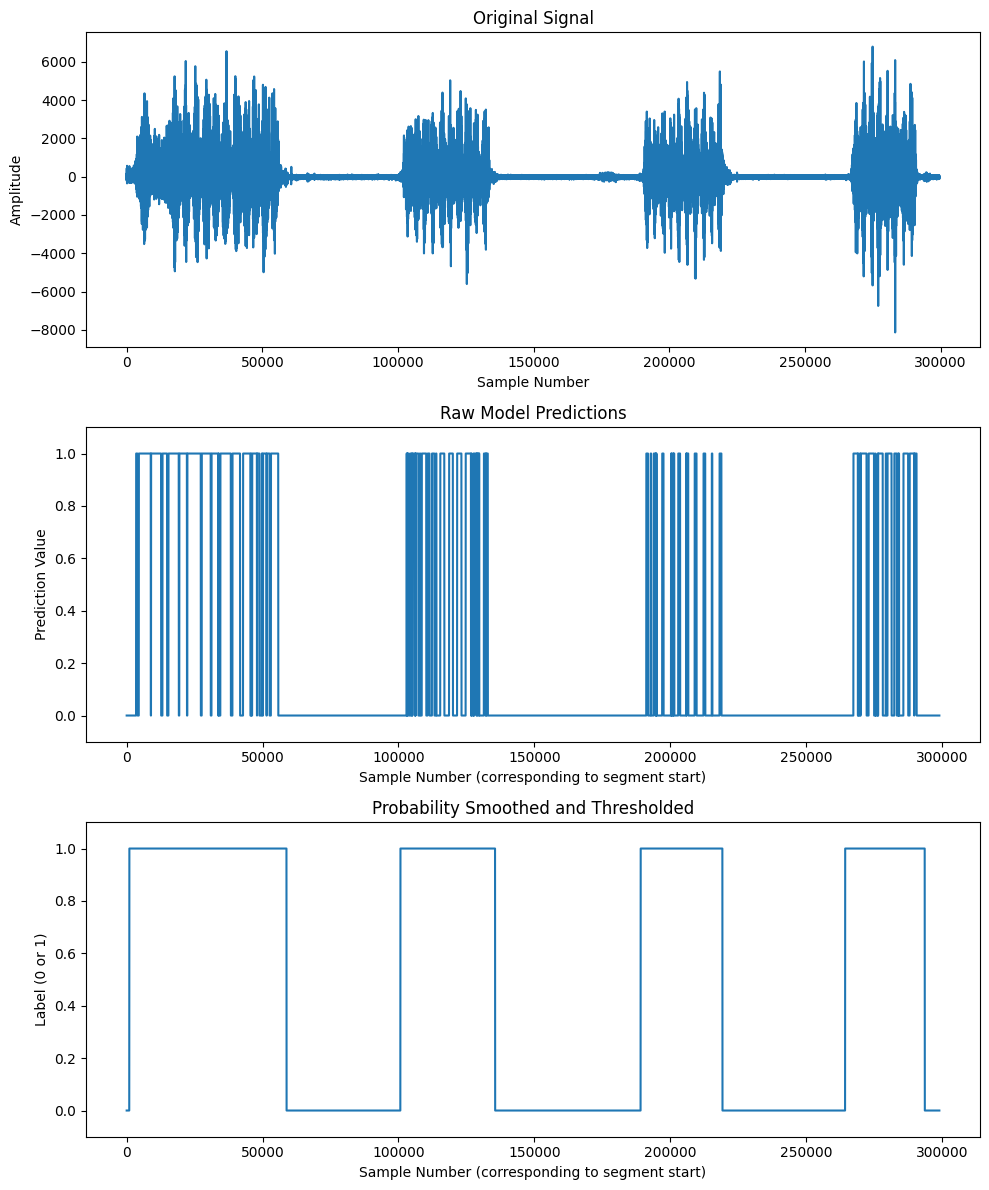

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with three subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False) # sharex=False as signal and predictions/withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index for the predictions
prediction_indices = np.arange(len(predictions)) * step_size_samples # Assuming each element corresponds to a segment start

# Plot the raw predictions
axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Raw Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[2].plot(withprob_indices, withprob)
axes[2].set_title('Probability Smoothed and Thresholded')
axes[2].set_xlabel('Sample Number (corresponding to segment start)')
axes[2].set_ylabel('Label (0 or 1)')
axes[2].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

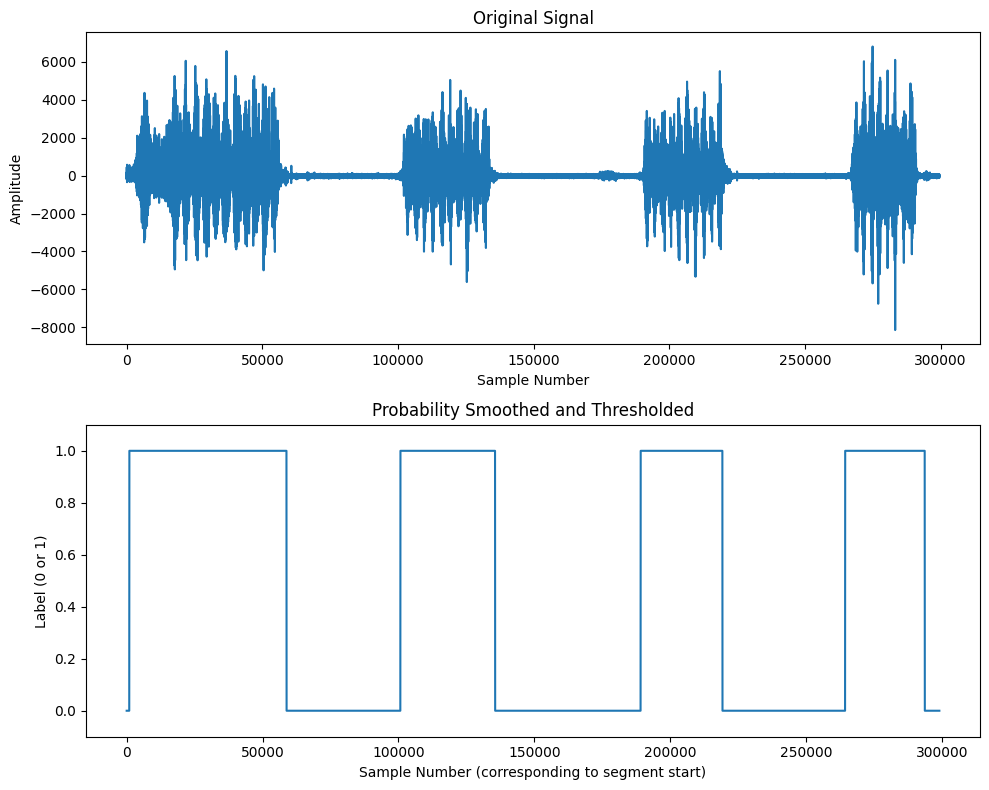

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False) # sharex=False as signal and withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[1].plot(withprob_indices, withprob)
axes[1].set_title('Probability Smoothed and Thresholded')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Label (0 or 1)')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()